In [185]:
import PySimpleGUI as sg
import cv2
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

from skimage import data, io, filters, transform
from skimage.filters import threshold_otsu, threshold_yen, threshold_minimum
from skimage.segmentation import clear_border, chan_vese
from skimage.exposure import rescale_intensity
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage import util 
import tifffile
import timeit

from PIL import Image, ImageOps 

#### defining of the array of coordinates for cropping box
boxes = []    
#### default scalling factor for preview of brightfield image
scaling_factor = 12 ### 6 for 100um and 12 for 300 um

#### flags for loading the image (*.tiff) with 3 channels [brigthfield, live, dead]
flag_img = 0
#### flag for cropping of the image
flag_crop = 0

#### flag for segmentation of the image (using grid or segmentation tool)
flag_seg = 0
#### flag for application of grid function
flag_grid = 0

#### defining of the images' variables
image_bf_raw = 0
image_live_raw = 0 
image_dead_raw = 0 
image_bf = 0
image_live = 0
image_dead = 0
num_channels = 0
#### name of the loaded file
im_bf = ''
#### path of the loaded file
path =''
#### name of the loaded file
file =''

#### default rotation of the image 
rotation =0
#### coordinates of wells
cords = []  
#### default number of result page for output
win_i = 1
#### default number of results per page for output
rows_page = 20
#### defining the results array
df_stats = []
frames = []

#### flags for loading of data for sample calculation
flag_df_neg_control = 0
flag_df_sample = 0
flag_df_pos_control = 0

#### parameters of the sample
rows = 4
columns = 50
radius = 85 ### [30 for 100 um] and [85 for 300um]
offset = 10
flag_100 = 0
flag_300 = 1
devices = 2


#### preview of the lodaed image
def show_img(image_raw, name, scale):
    cv2.namedWindow(name, cv2.WINDOW_AUTOSIZE)  
    image_print = transform.resize(image_raw, (image_raw.shape[0]//scale, image_raw.shape[1]//scale))   
    cv2.imshow(name,image_print)

#### defining the cropping area using the mouse
def on_mouse_crop(event, x, y, flags, params):
    global image_bf
    global image_live, image_dead
    global scaling_factor
    global flag_crop
    
    #### defining the first coordinate of box using left button click of the mouse
    if event == cv2.EVENT_LBUTTONDOWN:
        sbox = [x, y]
        boxes.append(sbox)
    
    #### defining the second coordinate of box using left button  of the mouse and cropping of the image
    elif event == cv2.EVENT_LBUTTONUP:
        ebox = [x, y]
        boxes.append(ebox)
        
        #### cropping the images
        image_bf = crop(image_bf, boxes[0][1]*scaling_factor, boxes[1][1]*scaling_factor,
                        boxes[0][0]*scaling_factor, boxes[1][0]*scaling_factor )
        
        image_live = crop(image_live, boxes[0][1]*scaling_factor, boxes[1][1]*scaling_factor, 
                             boxes[0][0]*scaling_factor, boxes[1][0]*scaling_factor )
        
        image_dead = crop(image_dead, boxes[0][1]*scaling_factor, boxes[1][1]*scaling_factor, 
                             boxes[0][0]*scaling_factor, boxes[1][0]*scaling_factor )
        
        #### turning off the cropping loop function
        flag_crop = 0
        cv2.setMouseCallback('BF', nothing)
        
        #### show updated brightfield image
        show_img(image_bf, 'BF', scaling_factor)

#### cropping of the image
def crop(image_raw, x_min, x_max, y_min, y_max):
    
    image = image_raw[int(x_min):int(x_max), int(y_min):int(y_max)]
    return image

def nothing(event, x, y, flags, params):
    pass

#segmentation of wells on the image
def segmentation(image):
    global scaling_factor
    
    #### applying OTSU threshold
    thresh = threshold_otsu(image)
    #print(thresh)
    
    #### closing and clearing the segments
    bw = closing(image > thresh, square(2))
    cleared = clear_border(bw)

    #### label image regions
    label_image = label(cleared)

    #### creation of the list of the coordinates 
    cords = []
    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 500:
            minr, minc, maxr, maxc = region.bbox
            y0, x0 = minr + (maxr - minr)/2, minc + (maxc - minc)/2
            cord = [x0,y0]
            cords.append(cord)
    
    cords = np.array(cords)
                
    return cords

#### defining of the coordinates of the wells using the grid
def grid(cord_1, cord_2, cord_3, cord_4, rows, columns, devices): 
    
    #### caclulation of the distances between the wells in the grid
    dy_rows = (cord_2[1] - cord_1[1])/(rows-1)
    dx_rows = (cord_2[0] - cord_1[0])/(rows-1)

    dy_columns = (cord_3[1] - cord_2[1])/(columns-1)
    dx_columns = (cord_3[0] - cord_2[0])/(columns-1)
    
    #### creation of 2D array of the coordinates of the wells
    wells = np.zeros((columns*devices,rows,2))
    wells[0][0] = cord_1
    wells[0][rows-1] = cord_2
    wells[columns-1][rows-1] = cord_3

    for i in range(columns):
        x = wells[0][0][0] + dx_columns*i
        y = wells[0][0][1] + dy_columns*i
        wells[i][0] = (x,y)

        for j in range(rows):
            x = wells[i][0][0] + dx_rows*j
            y = wells[i][0][1] + dy_rows*j
            wells[i][j] = (x,y)
    
    
    if (devices > 1):
        dy_devices = (cord_4[1] - cord_3[1])/(devices-1)
        dx_devices = (cord_4[0] - cord_3[0])/(devices-1)
        
        for k in range(devices-1):
                for i in range(columns):
                    x = wells[0][0][0] + dx_columns*i + dx_devices*(k+1)
                    y = wells[0][0][1] + dy_columns*i + dy_devices*(k+1)
                    wells[i+columns*(k+1)][0] = (x,y)

                    for j in range(rows):
                        x = wells[i+columns*(k+1)][0][0] + dx_rows*j 
                        y = wells[i+columns*(k+1)][0][1] + dy_rows*j
                        wells[i+columns*(k+1)][j] = (x,y)
            
    
    #### reshaping of 2D array to the list of the coordinates
    cords = np.reshape(wells,(-1,2))  
    cords.tolist()
    return cords

def grid_1ch(cord_1, cord_2, cord_3, columns, devices): 
    
    #### caclulation of the distances between the wells in the grid

    dy_columns = (cord_2[1] - cord_1[1])/(columns-1)
    dx_columns = (cord_2[0] - cord_1[0])/(columns-1)
    
    #### creation of 2D array of the coordinates of the wells
    wells = np.zeros((columns*devices,1,2))
    wells[0][0] = cord_1
    wells[columns-1][0] = cord_2

    for i in range(columns):
        x = wells[0][0][0] + dx_columns*i
        y = wells[0][0][1] + dy_columns*i
        wells[i][0] = (x,y)
        
    if (devices > 1):
        dy_devices = (cord_3[1] - cord_2[1])/(devices-1)
        dx_devices = (cord_3[0] - cord_2[0])/(devices-1)
        
        for k in range(devices-1):
            for i in range(columns):
                x = wells[0][0][0] + dx_columns*i + dx_devices*(k+1)
                y = wells[0][0][1] + dy_columns*i + dy_devices*(k+1)
                wells[i+columns*(k+1)][0] = (x,y)

    #### reshaping of 2D array to the list of the coordinates
    cords = np.reshape(wells,(-1,2))  
    cords.tolist()
    return cords

#### merging of the brightfield image and the defined regions
def draw_regions(cords, image):
    global radius
    image_bf_s = image.copy()
    
    for cord in cords:
        cent_x, cent_y = cord
        image_bf_s = cv2.circle(image_bf_s, (int(cent_x), int(cent_y)), radius, [0], 5)
    window['-SEG-'].update(len(cords))
    return image_bf_s
        
#### adding/removal of the region using the mouse left button click
def on_mouse_rem(event, x, y, flags, params):
    global cords
    global scaling_factor
    global image_bf
    global radius
    
    #### flag for the addition(FALSE)/removal(TRUE) of the region
    flag = 0
    
    if event == cv2.EVENT_LBUTTONDOWN:
        #### search for the existing region containing the chosen pixel
        for i, cord in enumerate(cords):
            cent_x, cent_y = cord
            if (x*scaling_factor > cent_x - radius) and (x*scaling_factor < cent_x + radius):
                if (y*scaling_factor > cent_y - radius) and (y*scaling_factor < cent_y + radius):
                    #### region was found: delete the region from the list and skip the addition of the region
                    flag = 1
                    cords = np.delete(cords, i, axis=0)
                    #### show updated regions
                    image_bf_s = draw_regions(cords, image_bf)
                    show_img(image_bf_s, 'Segment', scaling_factor)
                    
        #### region was NOT found: add a new region with the coordinates of the chosen pixel
        if flag == 0:
            l = len(cords)
            cord = np.array([(x*scaling_factor, y*scaling_factor)])
            cords = np.append(cords, cord).reshape(l+1, 2)
            #### show updated regions
            image_bf_s = draw_regions(cords, image_bf)
            show_img(image_bf_s, 'Segment', scaling_factor)
            
#### defining the grid using 3 points (1-top left, 2-bottom left, 3-bottom right) of the grid corners
def on_mouse_grid(event, x, y, flags, params):
    global cords
    global scaling_factor
    global image_bf
    global rows, columns, radius, devices
    global flag_grid, flag_seg
    
    #### add(FALSE)/remove(TRUE) point from the list
    #### to remove the point we need to left click on it once more time
    flag = 0
    
    if flag_grid == 1:
        if event == cv2.EVENT_LBUTTONDOWN:
            #### if the chosen pixel belongs to th already existing point - detete point
            for i, cord in enumerate(cords):
                cent_x, cent_y = cord
                if (x*scaling_factor > cent_x - radius) and (x*scaling_factor < cent_x + radius):
                    if (y*scaling_factor > cent_y - radius) and (y*scaling_factor < cent_y + radius):
                        flag = 1
                        cords = np.delete(cords, i, axis=0)
                        #### show updated regions
                        image_bf_s = draw_regions(cords, image_bf)
                        show_img(image_bf_s, 'Segment', scaling_factor)
                        
            
            #### add the point with the coordinates of the chosen pixel
            if flag == 0:
                l = len(cords)
                cord = np.array([(x*scaling_factor, y*scaling_factor)])
                cords = np.append(cords, cord).reshape(l+1, 2)
                #### if it was the THIRD point (all required coordinates have been chosen) - pass the function
                if ((len(cords) == 3) & (rows > 1)) & (devices == 1) :
                    
                    #### calculation of the coordinates of all the wells in the grid
                    cords = grid(cords[0], cords[1], cords[2], (0,0), rows, columns, devices)
                    flag_grid = 0
                    flag_seg = 1
                
                if ((len(cords) == 4) & (rows > 1)) & (devices > 1) :
                    
                    #### calculation of the coordinates of all the wells in the grid
                    cords = grid(cords[0], cords[1], cords[2], cords[3], rows, columns, devices)
                    flag_grid = 0
                    flag_seg = 1
                    
                if ((len(cords) == 3) & (rows == 1)) & (devices > 1) :
                    
                    #### calculation of the coordinates of all the wells in the grid
                    cords = grid_1ch(cords[0], cords[1], cords[2], columns, devices)
                    flag_grid = 0
                    flag_seg = 1
                    
                if ((len(cords)==2) & (rows == 1)) & (devices == 1):
                    
                    #### calculation of the coordinates of all the wells in the grid
                    cords = grid_1ch(cords[0], cords[1], (0,0), columns, devices)
                    flag_grid = 0
                    flag_seg = 1
                
                
                #### show updated regions

                image_bf_s = draw_regions(cords, image_bf)
                show_img(image_bf_s, 'Segment', scaling_factor)
                
    
            
                    
#### circular mask for intensity measurements of each well
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center >= radius
    return mask


#### calculation of the fluorescence intensities of the wells
def calc_fluo(regions, image, image_live, image_dead, num_channels):
    global radius, offset
    
    radius_mask = radius + offset
    stats = []
    frames =[]
    
    
    if num_channels == 1:

        masked_img = image.copy()    

        thresh = threshold_yen(masked_img)

        for i, region in enumerate(regions):

            #### mask image inside circle
            x0, y0 = region

            # crop image to circle of interest
            x_low = int(round(x0, 0)) - radius_mask
            x_high = int(round(x0, 0)) + radius_mask
            y_low = int(round(y0, 0)) - radius_mask
            y_high = int(round(y0, 0)) + radius_mask

            cropped_img = masked_img[y_low:y_high, x_low:x_high]
            frames.append((cropped_img))

            mask = create_circular_mask(w=radius_mask*2, h=radius_mask*2, center=(radius_mask, radius_mask), radius=radius)

            total_num_pixels = np.sum(~mask)
            
            cropped_img[mask] = 0
            # count how many pixels in mask/circle
            intensity_gray = np.sum(cropped_img) / total_num_pixels
            
            bw = closing(cropped_img < thresh, square(2))
            cleared = clear_border(bw)

            tot_num_pixels = np.sum(~bw)
            area = (total_num_pixels - tot_num_pixels)/total_num_pixels

            stats.append((x0, y0, area, intensity_gray))
    
    
    
    if num_channels == 2:

        masked_img = image.copy()    
        masked_img_live = image_live.copy()

        thresh = threshold_yen(masked_img)

        for i, region in enumerate(regions):

            #### mask image inside circle
            x0, y0 = region

            # crop image to circle of interest
            x_low = int(round(x0, 0)) - radius_mask
            x_high = int(round(x0, 0)) + radius_mask
            y_low = int(round(y0, 0)) - radius_mask
            y_high = int(round(y0, 0)) + radius_mask

            cropped_img = masked_img[y_low:y_high, x_low:x_high]
            cropped_img_live = masked_img_live[y_low:y_high, x_low:x_high]
                        
            frames.append((cropped_img, cropped_img_live))

            mask = create_circular_mask(w=radius_mask*2, h=radius_mask*2, center=(radius_mask, radius_mask), radius=radius)

            total_num_pixels = np.sum(~mask)

            cropped_img[mask] = 0
            cropped_img_live[mask] = 0

            #### calculate sum intensity
            #intensity = np.sum(masked_img) / num_active_pixels  # scale just to get lower number to look at
            intensity_gray = np.sum(cropped_img) / total_num_pixels
            intensity_live = np.sum(cropped_img_live) / total_num_pixels

            # count how many pixels in mask/circle

            bw = closing(cropped_img < thresh, square(2))
            cleared = clear_border(bw)

            tot_num_pixels = np.sum(~bw)
            area = (total_num_pixels - tot_num_pixels)/total_num_pixels

        
            stats.append((x0, y0, area, intensity_gray, intensity_live))


    
    
    if num_channels == 3:

        masked_img = image.copy()    
        masked_img_live = image_live.copy()
        masked_img_dead = image_dead.copy()

        thresh = threshold_yen(masked_img)

        for i, region in enumerate(regions):

            #### mask image inside circle
            x0, y0 = region

            # crop image to circle of interest
            x_low = int(round(x0, 0)) - radius_mask
            x_high = int(round(x0, 0)) + radius_mask
            y_low = int(round(y0, 0)) - radius_mask
            y_high = int(round(y0, 0)) + radius_mask

            cropped_img = masked_img[y_low:y_high, x_low:x_high]
            cropped_img_live = masked_img_live[y_low:y_high, x_low:x_high]
            cropped_img_dead = masked_img_dead[y_low:y_high, x_low:x_high]
            frames.append((cropped_img, cropped_img_live, cropped_img_dead))

            mask = create_circular_mask(w=radius_mask*2, h=radius_mask*2, center=(radius_mask, radius_mask), radius=radius)

            total_num_pixels = np.sum(~mask)

            cropped_img[mask] = 0
            cropped_img_live[mask] = 0
            cropped_img_dead[mask] = 0

            #### calculate sum intensity
            #intensity = np.sum(masked_img) / num_active_pixels  # scale just to get lower number to look at
            intensity_gray = np.sum(cropped_img) / total_num_pixels
            intensity_live = np.sum(cropped_img_live) / total_num_pixels
            intensity_dead = np.sum(cropped_img_dead) / total_num_pixels 

            # count how many pixels in mask/circle

            bw = closing(cropped_img < thresh, square(2))
            cleared = clear_border(bw)

            tot_num_pixels = np.sum(~bw)
            area = (total_num_pixels - tot_num_pixels)/total_num_pixels
            
            stats.append((x0, y0, area, intensity_gray, intensity_live, intensity_dead, intensity_live/intensity_dead, ratio_viability(intensity_live/intensity_dead)))

    return stats, frames

#### show the output results as a table
def show_table(stats, win_i):
    global rows_page
    global num_channels

    
    #### defining the strusture of the table
    if num_channels == 1:
        headings =  ['index','x0', 'y0', 'Area','Int_gray','Row','Column','Device']
        
    if num_channels == 2:
        headings =  ['index','x0', 'y0', 'Area','Int_gray','Int_live','Row','Column', 'Device']
    
    if num_channels == 3:    
        headings =  ['index','x0', 'y0', 'Area','Int_gray','Int_live','Int_dead', 'Ratio','Viability','Row','Column','Device']
        
    header =  [[sg.Text('  ')] + [sg.Text(h, size=(14,1)) for h in headings]]
    input_rows = []
    
    #### print the results from l to m number
    m = win_i*rows_page-1
    l = (win_i-1)*rows_page
    
    if m > len(stats): m = len(stats)
    
    for i in range(l,m):
        row = []
        for j in range(len(stats.columns)):
            val = stats.iat[i,j]
            
            row.append(sg.Text(val, size=(14,1)))
        #row = [sg.Text(i, size=(14,1))]
        input_rows.append(row)
   
    buttons = [[sg.Button('Previous'), sg.Button('Next')], 
               [sg.Button('Save results'), sg.Button('Save images'),],
               [sg.Button('Analysis of images'), sg.Button('Main menu'), sg.Button('Quit')]]
    

    layout = header + input_rows + buttons
    return layout


#### calculation of the cell viability for each well
def cell_viability_single(df_n_control,df_sample,df_p_control):
    global rows, columns
    i = 0 
    df = pd.DataFrame(columns=['row', 'index', 'neg_contr','sample','pos_contr','cell_viability'])
    for row in range(rows):
        for index in range(columns):
            try:
                n_control = df_n_control[(df_n_control["row"] == row+1) & (df_n_control["index"] == index)]['Int'].values[0]
                #filling = df_n_control[(df_n_control["row"] == row+1) & (df_n_control["index"] == index)]['Well-filled'].values[0]
                sample = df_sample[(df_sample["row"] == row+1) & (df_sample["index"] == index)]['Int'].values[0]
                p_control = df_p_control[(df_p_control["row"] == row+1) & (df_p_control["index"] == index)]['Int'].values[0]
                cell_viability = (sample - p_control)/(n_control - p_control)*100
                df.loc[i] = [row+1, index, n_control, sample, p_control, cell_viability]
                i = i+1    
            except:
                pass
            

    return df


def ratio_viability(value, live_range = [0.011, 0.12], dead_range = [0.09, 0.01], resolution = 0.01): #### ranges [c_0, c_100]
    step = int(100/resolution)
    live = np.linspace(live_range[0], live_range[1], num=step)
    dead = np.linspace(dead_range[0], dead_range[1], num=step)
    ratio = np.divide(live,dead)
        
    index = -1
    #### search through the table data
    for i in range(step):
        if (ratio[i]-value) >= 0:
            index = i
            break
            
    viability = index/step*100
    
    if (index == -1) and (value < ratio[0]):
        viability = 0
    
    if (index == -1) and (value > ratio[step-1]):
        viability = 101 
    
    return viability


def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist,bins = np.histogram(image.ravel(),512,range=[0,1])
    hist_size = len(hist)


    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size - 1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray) *255
    #beta = -minimum_gray * alpha
    beta = 0
    
    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)



layout = [[sg.Button('Analysis of images')],
                  [sg.Button('Synergy')],
                  [sg.Text()],
                  [sg.Button('Settings'),sg.Button('Quit')]]
window = sg.Window('Main menu', layout)



while True:
    event, values = window.read()
    
    if event == 'Analysis of images':
        window.close()
        if flag_img == 0:
            layout = [[sg.Button('Load image')],
                      [sg.Button('Main menu'), sg.Button('Quit')]]
            window = sg.Window('Loading of images', layout) 

        if flag_img == 1:
            if (num_channels == 1):
                layout = [[sg.Button('Edit images'), sg.Button('Grid')],
                          [sg.Button('Add/Remove segments')],
                          [sg.Txt(size=(8,1), key='-SEG-')],
                          [sg.Button('Calculate')],
                          [sg.Txt('Bright', size=(6,1)) ],
                          
                          [sg.Text()],
                          [sg.Button('Load image')], 
                          [sg.Button('Main menu'), sg.Button('Quit')]]
                window = sg.Window('Analysis', layout)
            
            if (num_channels == 2):
                layout = [[sg.Button('Edit images'), sg.Button('Grid')],
                          [sg.Button('Add/Remove segments')],
                          [sg.Txt(size=(8,1), key='-SEG-')],
                          [sg.Button('Calculate')],
                          [sg.Txt('Bright', size=(6,1)), sg.Txt(' - ', size=(3,1)), sg.Txt('Live', size=(4,1), text_color='lime green')],
                          
                          [sg.Text()],
                          [sg.Button('Load image')], 
                          [sg.Button('Main menu'), sg.Button('Quit')]]
                window = sg.Window('Analysis', layout)
            
            
            if (num_channels == 3):
                layout = [[sg.Button('Edit images'), sg.Button('Grid')],
                          [sg.Button('Add/Remove segments')],
                          [sg.Txt(size=(8,1), key='-SEG-')],
                          [sg.Button('Calculate')],
                          [sg.Txt('Bright', size=(6,1)), sg.Txt(' - ', size=(3,1)), sg.Txt('Live', size=(4,1), text_color='lime green'), sg.Txt(' - ', size=(3,1)), sg.Txt('Dead', size=(4,1), text_color='red') ],
                          [sg.Text()],
                          [sg.Button('Load image')], 
                          [sg.Button('Main menu'), sg.Button('Quit')]]
                window = sg.Window('Analysis', layout)
            
    
    
    if event == 'Load image' :
        im_bf = sg.popup_get_file('Enter the file you wish to process')
        if not im_bf:
            sg.popup("Cancel", "No filename supplied")
        else:
            path, file = os.path.split(im_bf)
            file  = file.split('.',1)[0]
                                        
            rotation = 0
            flag_img = 1         
            boxes = []    
            flag_seg = 0
            cords = []  
            win_i = 1            
            df_stats = []
            
            #image_bf_raw = io.imread(im_bf)
            image_raw = io.imread(im_bf)

            if image_raw.ndim == 2:
                num_channels = 1
            if image_raw.ndim == 3:    
                num_channels = min(image_raw.shape)
            
            if (num_channels == 1):
                image_bf_raw = image_raw.copy()

                image_bf_raw = transform.rotate(image_bf_raw, rotation)
                
                image_bf = image_bf_raw.copy()

                cv2.destroyWindow('Segment')
                image_bf, alpha, beta = automatic_brightness_and_contrast(image_bf)
                show_img(image_bf, 'BF', scaling_factor)
                

                window.close()
                
                layout = [[sg.Button('Edit images'), sg.Button('Grid')],
                          [sg.Button('Add/Remove segments')],
                          [sg.Txt(size=(8,1), key='-SEG-')],
                          [sg.Button('Calculate')],
                          [sg.Txt('Bright', size=(6,1)) ],
                          
                          [sg.Text()],
                          [sg.Button('Load image')], 
                          [sg.Button('Main menu'), sg.Button('Quit')]]
                window = sg.Window('Analysis', layout)
            
            if (num_channels == 2):
                image_bf_raw = image_raw[0,:,:].copy()
                image_live_raw = image_raw[1,:,:].copy()

                image_bf_raw = transform.rotate(image_bf_raw, rotation)
                image_live_raw = transform.rotate(image_live_raw, rotation)
                
                image_bf = image_bf_raw.copy()
                image_live = image_live_raw.copy()

                cv2.destroyWindow('Segment')
                image_bf, alpha, beta = automatic_brightness_and_contrast(image_bf)
                show_img(image_bf, 'BF', scaling_factor)
                

                
                window.close()
                
                layout = [[sg.Button('Edit images'), sg.Button('Grid')],
                          [sg.Button('Add/Remove segments')],
                          [sg.Txt(size=(8,1), key='-SEG-')],
                          [sg.Button('Calculate')],
                          [sg.Txt('Bright', size=(6,1)), sg.Txt(' - ', size=(3,1)), sg.Txt('Live', size=(4,1), text_color='lime green')],
                          
                          [sg.Text()],
                          [sg.Button('Load image')], 
                          [sg.Button('Main menu'), sg.Button('Quit')]]
                window = sg.Window('Analysis', layout)
            
            
            if (num_channels == 3):
                
                image_bf_raw = image_raw[:,:,0].copy()
                image_live_raw = image_raw[:,:,1].copy()
                image_dead_raw = image_raw[:,:,2].copy()


                image_bf_raw = transform.rotate(image_bf_raw, rotation)
                image_live_raw = transform.rotate(image_live_raw, rotation)
                image_dead_raw = transform.rotate(image_dead_raw, rotation)

                image_bf = image_bf_raw.copy()
                image_live = image_live_raw.copy()
                image_dead = image_dead_raw.copy()
                cv2.destroyWindow('Segment')
                image_bf, alpha, beta = automatic_brightness_and_contrast(image_bf)
                show_img(image_bf, 'BF', scaling_factor)
                

                
                window.close()
                
                layout = [[sg.Button('Edit images'), sg.Button('Grid')],
                          [sg.Button('Add/Remove segments')],
                          [sg.Txt(size=(8,1), key='-SEG-')],
                          [sg.Button('Calculate')],
                          [sg.Txt('Bright', size=(6,1)), sg.Txt(' - ', size=(3,1)), sg.Txt('Live', size=(4,1), text_color='lime green'), sg.Txt(' - ', size=(3,1)), sg.Txt('Dead', size=(4,1), text_color='red') ],
                          [sg.Text()],
                          [sg.Button('Load image')], 
                          [sg.Button('Main menu'), sg.Button('Quit')]]
                window = sg.Window('Analysis', layout)
                
            if num_channels == 0:
                sg.popup("Cancel", "Please load the stack with at least 1 channel")
            
  
    if event == 'Edit images':
        window.close()
        layout = [[sg.Text("Rotation"), sg.InputText('0', size=(6, 1), key="Rot_input"), sg.Button('Rotate')],
                  [sg.Button('Crop image'),sg.Button('Autocontrast')],
                  [sg.Text()],
                  [sg.Button('Analysis of images'), sg.Button('Defaults'), sg.Button('Quit')]]
        window = sg.Window('Edit images', layout) 
       
        show_img(image_bf, 'BF', scaling_factor)
    
    if event == 'Autocontrast':
        image_bf, alpha, beta = automatic_brightness_and_contrast(image_bf)
        show_img(image_bf, 'BF', scaling_factor)

                  
    if event == 'Crop image':
        boxes = []
        flag_crop = 1
        if flag_crop == 1:
            cv2.setMouseCallback('BF', on_mouse_crop)
        else:
            cv2.setMouseCallback('BF', nothing)
        
    
    if event == 'Defaults':
        if num_channels == 1:
            image_bf = image_bf_raw
        if num_channels == 2:
            image_bf = image_bf_raw
            image_live = image_live_raw
        if num_channels == 3:
            image_bf = image_bf_raw
            image_live = image_live_raw
            image_dead = image_dead_raw
            
        show_img(image_bf, 'BF', scaling_factor)
    
    if event == 'Rotate':
        rotation = float(values["Rot_input"])
        if num_channels == 1:
            image_bf = transform.rotate(image_bf, rotation)

        if num_channels == 2:
            image_bf = transform.rotate(image_bf, rotation)
            image_live = transform.rotate(image_live, rotation)
        
        if num_channels == 3:
            image_bf = transform.rotate(image_bf, rotation)
            image_live = transform.rotate(image_live, rotation)
            image_dead = transform.rotate(image_dead, rotation)
  
        show_img(image_bf, 'BF', scaling_factor)

    
    if event == 'Segmentation':
            cv2.destroyAllWindows()
            image = image_bf.copy()
            cords = segmentation(image)
            image_bf_s = draw_regions(cords, image)
            show_img(image_bf_s, 'Segment', scaling_factor)
            flag_seg = 1
            
    if event == 'Grid':
            cv2.destroyAllWindows()
            image = image_bf.copy()
            cords = []
            flag_grid = 1
            image_bf_s = draw_regions(cords, image)
            show_img(image_bf_s, 'Segment', scaling_factor)
            cv2.setMouseCallback('Segment', on_mouse_grid)

        
    if event == 'Add/Remove segments':
        if flag_seg == 1:
            cv2.setMouseCallback('Segment', on_mouse_rem)
    
    if event == 'Calculate':
        if (flag_img == 1) & flag_seg == 1:
            stats, frames = calc_fluo(cords, image_bf, image_live, image_dead, num_channels)
            #### converting the results in the dataframe format
            
            df_stats = pd.DataFrame(data=stats)
            
            if num_channels == 1:
                df_stats.columns = ['x0', 'y0', 'Area','Int_gray']
            
            if num_channels == 2:
                df_stats.columns = ['x0', 'y0', 'Area','Int_gray','Int_live']
            
            if num_channels == 3:
                df_stats.columns = ['x0', 'y0', 'Area','Int_gray','Int_live', 'Int_dead', 'Ratio','Viability']
            
            
            #### calculation of the position of the well in the grid
            

            df_stats = df_stats.reset_index()
            num_wells = rows* columns
            df_stats['device'] = (df_stats['index'] // num_wells)+1
            df_stats['row'] = ((df_stats['index'] % num_wells) % rows)+1
            df_stats['column'] = ((df_stats['index'] % num_wells) // rows)+1
            
            ''' requires corrections
            else:
                if (rows >1):
                    y1 = min(df_stats['y0'])
                    y2 = max(df_stats['y0'])
                    dy = (y2-y1)/(rows - 1)
                    df_stats['row'] = round((df_stats['y0']-y1)/dy) +1
                if (rows == 1):
                    df_stats['row'] = 1

                x1 = min(df_stats['x0'])
                x2 = max(df_stats['x0'])
                dx = (x2-x1)/(columns - 1)
                df_stats['index'] = round((df_stats['x0']-x1)/dx)
            '''
            
            df_stats = df_stats.sort_values(by = ["device","row","x0"], ignore_index = None)
                
            
            window.close()            
            layout = show_table(df_stats, win_i)
            window = sg.Window('Calculations', layout)
            if num_channels == 3:
                sg.popup("Cell viability", df_stats['Viability'].mean())
    
    if event == 'Settings':
        if flag_300:
            window.close()
            layout = [[sg.Radio('100 uM', 1, key='-100-')],
                      [sg.Radio('300 uM', 1, key='-300-', default=True)],
                      [sg.Text("Rows"), sg.InputText(rows, size=(6, 1), key="Row_input")],
                      [sg.Text("Columns"), sg.InputText(columns, size=(6, 1), key="Columns_input")],
                      [sg.Text("Devices"), sg.InputText(devices, size=(6, 1), key="Devices_input")],
                      [sg.Button('Update')],
                      [sg.Text()],
                      [sg.Button('Main menu'), sg.Button('Quit')]]
            window = sg.Window('Main menu', layout)
        if flag_100:
            window.close()
            layout = [[sg.Radio('100 uM', 1, key='-100-', default=True)],
                      [sg.Radio('300 uM', 1, key='-300-')],
                      [sg.Text("Rows"), sg.InputText(rows, size=(6, 1), key="Row_input")],
                      [sg.Text("Columns"), sg.InputText(columns, size=(6, 1), key="Columns_input")],
                      [sg.Button('Update')],
                      [sg.Text()],
                      [sg.Button('Main menu'), sg.Button('Quit')]]
            window = sg.Window('Main menu', layout)
        

    if event == 'Update':
        rows = int(values["Row_input"])
        columns = int(values["Columns_input"])
        devices = int(values["Devices_input"])
        if values['-100-']:
            radius = 30
            scaling_factor = 6
            flag_100 = 1
            flag_300 = 0
        if values['-300-']:
            radius = 85
            scaling_factor = 12 
            flag_100 = 0
            flag_300 = 1
                   
        
            
    if event == 'Previous':
        if win_i == 1:
            pass
        else:
            win_i -= 1
            window.close()
            layout = show_table(df_stats, win_i)
            window = sg.Window('Calculations', layout)
        
    if event == 'Next':
        if win_i*rows_page >= len(df_stats):
            pass
        else:
            win_i += 1
            window.close()
            layout = show_table(df_stats, win_i)
            window = sg.Window('Calculations', layout)

    
    '''
    if event == 'Cell viability' :
        window.close()
        layout = [[sg.Button('Load negative control'), sg.Text('None', key='-NEG_CONTROL-')],
                  [sg.Button('Load sample'), sg.Text('None', key='-SAMPLE-')],
                  [sg.Button('Load positive control'), sg.Text('None  ', key='-POS_CONTROL-')],
                  [sg.Radio('By single spheroid', 1, key='-SINGLE-', default=True)],
                  [sg.Radio('By row', 1, key='-ROW-')],
                  [sg.Radio('By chip', 1, key='-CHIP-')],
                  [sg.Button('Calculate cell viability')],
                  [sg.Text()],
                  [sg.Button('Show statistics'), sg.Button('Save results')],
                  [sg.Button('Main menu'), sg.Button('Quit')]]
        window = sg.Window('Main menu', layout)
    '''
        
    if event == 'Load negative control' :
            name_df_neg_control = sg.popup_get_file('Enter the file you wish to process')
            if not name_df_neg_control:
                sg.popup("Cancel", "No filename supplied")
            else:
                df_neg_control = pd.read_csv(name_df_neg_control)
                window['-NEG_CONTROL-'].update('Loaded')
                flag_df_neg_control = 1
                    
    if event == 'Load sample' :
            name_df_sample = sg.popup_get_file('Enter the file you wish to process')
            if not name_df_sample:
                sg.popup("Cancel", "No filename supplied")
            else:
                df_sample = pd.read_csv(name_df_sample)
                window['-SAMPLE-'].update('Loaded')
                flag_df_sample = 1

    if event == 'Load positive control' :
            name_df_pos_control = sg.popup_get_file('Enter the file you wish to process')
            if not name_df_pos_control:
                sg.popup("Cancel", "No filename supplied")
            else:
                df_pos_control = pd.read_csv(name_df_pos_control)
                window['-POS_CONTROL-'].update('Loaded')
                flag_df_pos_control = 1

    if event == 'Calculate cell viability' :
        if (flag_df_neg_control == 1 & flag_df_pos_control == 1) & flag_df_sample == 1:
            
            df_cell_viability = cell_viability_single(df_neg_control,df_sample,df_pos_control)
            #df_true = df_cell_viability[df_cell_viability['Well-filled'] == True]
            
            if values['-SINGLE-']:
      
                mean_live = df_cell_viability['cell_viability'].mean()       

                  
            if values['-CHIP-']:
                mean_neg_control = df_cell_viability['neg_contr'].mean()
                mean_pos_control = df_cell_viability['pos_contr'].mean()  
                mean_sample = df_cell_viability['sample'].mean() 
                mean_live = (mean_sample - mean_pos_control)/(mean_neg_control - mean_pos_control)*100         
                
            sg.popup("Cell viability", mean_live)
        else:
            sg.popup('Please load the data')
    
    if event == 'Save results':
                try:
                    if (devices == 1):
                        df_stats.to_csv(path  +'/'+ file +'_report.csv',index=True)
                        sg.popup("Done","Saved in" + path)
                    if (devices > 1):    
                        for i in range(devices):
                            df = df_stats[df_stats.device == i]
                            df.to_csv(path  +'/'+ file +'_dev'+str(i)+'_report.csv',index=True)
                        sg.popup("Cancel","Saved " +str(devices) +" reports in" + path)
                except:
                    sg.popup("Cancel", "Error")
                    
    if event == 'Save images':
                try:
                    for i, frame in enumerate(frames):                  
                        io.imsave(path+ '/images/' + str(i) + '.tiff', np.array(frame))                    
                    labels = df_stats.sort_values(by = ["index"], ignore_index = None)['Viability']
                    labels.to_csv(path+ '/images/labels.csv',index=True)
                    
                    sg.popup("Cancel","Saved " +str(len(frames)) +" images in " + path+ '/images/')
                        
                except:
                    sg.popup("Cancel", "Error")
            
    
    
    if event == 'Main menu' :
        window.close()
        layout = [[sg.Button('Analysis of images')],
                  [sg.Button('Synergy')],
                  [sg.Text()],
                  [sg.Button('Settings'),sg.Button('Quit')]]
        window = sg.Window('Main menu', layout)
        
        
    if event == 'Quit' or event == sg.WIN_CLOSED :
        break

# Finish up by removing from the screenindow.close()
cv2.destroyAllWindows()

In [15]:
import PySimpleGUI as sg
import cv2
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

from matplotlib.ticker import NullFormatter  # useful for `logit` scale
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import PySimpleGUI as sg
import matplotlib
#matplotlib.use('TkAgg')


def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg




layout = [[sg.Button('Main menu')],
                  [sg.Canvas(key='-CANVAS-')],
                  [sg.Text()],
                  [sg.Button('Quit')]]




fig = matplotlib.figure.Figure(figsize=(5, 4), dpi=100)
t = np.arange(0, 3, .01)
fig.add_subplot(111).plot(t, 2 * np.sin(2 * np.pi * t))

# create the form and show it without the plot
window = sg.Window('Demo Application - Embedding Matplotlib In PySimpleGUI', layout, finalize=True, element_justification='rigth', font='Helvetica 18')

# add the plot to the window
fig_canvas_agg = draw_figure(window['-CANVAS-'].TKCanvas, fig)


while True:
    event, values = window.read()
    

    if event == 'Main menu' :
        window.close()
        layout = [[sg.Button('Analysis of images')],
                  [sg.Button('Synergy')],
                  [sg.Text()],
                  [sg.Button('Settings'),sg.Button('Quit')]]
        window = sg.Window('Main menu', layout)
        
        
    if event == 'Quit' or event == sg.WIN_CLOSED :
        break

# Finish up by removing from the screenindow.close()
cv2.destroyAllWindows()


In [62]:
devices

2

In [64]:
len(cords)

800

In [65]:
columns*rows

200

In [184]:
df_stats

,index,x0,y0,Area,Int_gray,Int_live,Int_dead,Ratio,Viability
0,0,240.000000,864.00000,0.799471,76.795720,0.026262,0.018528,1.417414,52.41
1,1,264.000000,1320.00000,0.804103,81.652857,0.020435,0.015752,1.297295,49.70
2,2,288.000000,1776.00000,0.707346,79.420340,0.045268,0.019782,2.288291,66.75
3,3,312.000000,2232.00000,0.587823,84.857975,0.030691,0.019794,1.550497,55.16
4,4,300.244898,861.55102,0.783102,64.809398,0.020684,0.014047,1.472461,53.58
...,...,...,...,...,...,...,...,...,...
395,395,16271.755102,1766.44898,0.799250,53.797838,0.028974,0.007251,3.995870,81.32
396,396,16260.000000,396.00000,0.910302,49.239312,0.030747,0.009961,3.086801,74.96
397,397,16284.000000,852.00000,0.862078,52.085330,0.025873,0.008660,2.987536,74.10
398,398,16308.000000,1308.00000,0.902405,44.745025,0.032589,0.008456,3.854032,80.48


In [114]:
df1 = df_stats.reset_index()

In [166]:
num_wells = rows* columns
df1['device'] = (df1['level_0'] // num_wells)+1
df1['row'] = ((df1['level_0'] % num_wells) % rows)+1
df1['index'] = ((df1['level_0'] % num_wells) // rows)+1


AttributeError: 'DataFrame' object has no attribute 'sort'

In [172]:
tail.split('.',1)[0]

'Stack'

In [142]:
rows

4

In [186]:
df_stats

,index,x0,y0,Area,Int_gray,Int_live,Int_dead,Ratio,Viability,device,row,column
0,0,264.000000,888.000000,0.757909,79.169512,0.023168,0.016969,1.365298,51.27,1,1,1
4,4,337.224490,885.551020,0.555967,79.337745,0.012582,0.010438,1.205364,47.45,1,1,2
8,8,410.448980,883.102041,0.302493,89.756276,0.005542,0.005332,1.039458,42.96,1,1,3
12,12,483.673469,880.653061,0.460049,79.317317,0.008549,0.007278,1.174727,46.67,1,1,4
16,16,556.897959,878.204082,0.677829,64.384249,0.014752,0.011423,1.291444,49.56,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
383,383,16015.102041,1701.795918,0.663975,64.934348,0.028788,0.008182,3.518556,78.28,2,4,46
387,387,16088.326531,1699.346939,0.613589,65.885727,0.007842,0.005788,1.354767,51.03,2,4,47
391,391,16161.551020,1696.897959,0.638297,64.495522,0.011994,0.005743,2.088601,64.10,2,4,48
395,395,16234.775510,1694.448980,0.761527,55.256431,0.041623,0.008080,5.151321,86.85,2,4,49


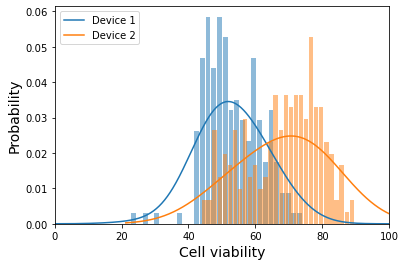

In [275]:
fig, ax = plt.subplots()

#n, bins, patches = ax.hist(x=df_stats[df_stats.device ==1]['Viability'], bins=30, color='red', alpha=0.7, rwidth=0.85)

#n, bins, patches = ax.hist(x=df_stats[df_stats.device ==2]['Viability'], bins=30, color='blue',alpha=0.7, rwidth=0.85)


def plot_hist(data, ax, bins):
    labels = []
    color_scheme = plt.cm.get_cmap('tab10')
    for i, dev in enumerate(df_stats['device'].unique()):
        df_stats[df_stats.device == dev]['Viability'].plot.hist(density=True, ax=ax, bins = bins, color = color_scheme(i), alpha=0.5, rwidth=0.85)
        df_stats[df_stats.device == dev]['Viability'].plot.kde(ax=ax, legend=True, bw_method=1, color = color_scheme(i))
        labels.append('Device ' + str(i+1))

    ax.set_ylabel('Probability', fontsize = 14)
    ax.set_xlim(0,100)
    ax.set_xlabel('Cell viability', fontsize = 14)
    ax.legend(labels)
    
plot_hist(df_stats, ax, 30)

